In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, make_scorer, confusion_matrix, accuracy_score

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [2]:
# Provided dataset
X_train = np.load('mnist1_features_train.npy', allow_pickle=True)
y_train = np.load('mnist1_labels_train.npy', allow_pickle=True)
X_test = np.load('mnist1_features_test.npy', allow_pickle=True)
y_test = np.load('mnist1_labels_test.npy', allow_pickle=True)

In [ ]:
# Complete dataset
import tensorflow as tf
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Reduction to 30 %
n_train_samples = int(X_train.shape[0] * 0.30)
n_test_samples = int(X_test.shape[0] * 0.30)

train_indices = np.random.choice(X_train.shape[0], n_train_samples, replace=False)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.random.choice(X_test.shape[0], n_test_samples, replace=False)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [3]:
n_samples, n_features = X_train.shape # extract dimensions of the design matrix
print('Train data contains: {} samples of dimension {}'.format(n_samples, n_features))
print('Test data contains: {} samples'.format(X_test.shape[0]))

Train data contains: 2000 samples of dimension 784
Test data contains: 200 samples


In [4]:
# Conversion of labels to integers, necessary for custom scores to work
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Part 2

The data that we have contains images with $10$ classes. Normally, accuracy is a reasonable choice of the loss function to be optimized, but in this problem we *really* do not like when digits from $\{5, 6, 7, 8, 9\}$ are predicted to be from $\{0, 1, 2, 3, 4\}$.

**Question:** Propose a loss function that would address our needs. Explain your choice.

**Question:** Following above examples, make an ML pipeline that uses *your* loss function and finds appropriate classifiers.

When writing your report on this part, include:
   1. description of your loss function
   2. description of the pipeline
   3. description of the algorithms that you used 

**Answer:**
The wording of this questions was confusing to us. As far as we understand, the <i>loss function</i> is used to make algorithms converge and is hardcoded in sklearn, thus, impossible to customize. What is customized in the code abode is the <i>score function</i>, which is used after the models have converged to select those with the best fit. This means in particular, if all models belong to the same class, to identify the best hyperparameter(s) value(s). So what we can do here will not change the algorithms' behavior in any way, only the assessment of their results.

For this approach to be effective, we need algorithms that produce contrasted results with regards to our specific criteria, i.e., the misclassification of 5-9 digits as 0-4 as opposed to other misclassifications. In such circumstances, changing the scoring rule can lead to the selection of an algorithm misclassifying less often 5-9 digits as 0-4, but making more prediction errors overall. Without such a tradeoff between these two performance metrics, i.e., for algorithms that perform similarily on all prediction tasks, changing the scoring rule will have no effect on model selection: we will always end up with the same, best-performing model.

So, before even writing a custom scoring function, we checked wheter trade-offs exist between the two types of errors we are interested in.

## Trades-off between misclassification types
We used ```cross_validate()``` to get the same results as ```gridsearchCV()``` (which ranks model according to their performance on the train sample only, using k-fold validation). We used custom scorer to count misclassifications, in order to simplify the code. We also enlarged the paramater space of each classifier to get a better view of their behavior. We have considered:
- kNN
- logistic regression
- linearSVC
- SVC

In [5]:
# Custom scores to count misclassifications
def sub_misclass_count(y_true, y_pred):
    sub_misclass = np.sum((y_pred < 5) & (y_true >= 5))
    return sub_misclass

def all_misclass_count(y_true, y_pred):
    all_misclass = np.sum(y_pred != y_true)
    return all_misclass

sub_misclass_counter = make_scorer(sub_misclass_count)
all_misclass_counter = make_scorer(all_misclass_count)

In [6]:
# Function to plot performance metrics vs hyperparameter
def plot_results(results, h, graph_title, filename):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    if h == 'k':
        ax1.plot(results[h], results['sub_misclass'], 'b-', label='5-9 to 0-4 Misclassifications')
        ax1.plot(results[h], results['all_misclass'], 'r-', label='All Misclassifications')
        ax2.plot(results[h], results['accuracy'], 'g-', label='Accuracy')
        ax2.plot(results[h], results['balanced_accuracy'], 'y-', label='Balanced accuracy')
    elif h == 'C':
        ax1.semilogx(results[h], results['sub_misclass'], 'b-', label='5-9 to 0-4 Misclassifications')
        ax1.semilogx(results[h], results['all_misclass'], 'r-', label='All Misclassifications')
        ax2.semilogx(results[h], results['accuracy'], 'g-', label='Accuracy')
        ax2.semilogx(results[h], results['balanced_accuracy'], 'y-', label='Balanced accuracy')
    
    ax1.set_xlabel(h)
    ax1.set_ylabel('Number of Misclassifications')
    ax1.set_title(f'Misclassifications vs. {graph_title}')
    ax1.legend()
    ax1.grid(True)

    ax2.set_xlabel(h)
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Accuracy vs. {graph_title}')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.show()

# Function to add stars to the best values
def add_star(series, find_min=True):
    if find_min:
        idx = series.idxmin()
    else:
        idx = series.idxmax()
    return series.astype(str).map(lambda x: f"{x}*" if x == str(series[idx]) else x)

# Function to format the detailed results
def format_results(results):
    results = results.round(3)
    results['accuracy'] = add_star(results['accuracy'], find_min=False)
    results['balanced_accuracy'] = add_star(results['balanced_accuracy'], find_min=False)
    results['sub_misclass'] = add_star(results['sub_misclass'])
    results['all_misclass'] = add_star(results['all_misclass'])
    return results

### kNN

In [7]:
results = []

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for k in k_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance'))]) 
    cv_results = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv=3, 
        scoring={'accuracy': 'accuracy', 
                 'balanced_accuracy': 'balanced_accuracy', 
                 'all_misclass' : all_misclass_counter,
                 'sub_misclass': sub_misclass_counter})
    results.append({
        'k': k,
        'accuracy': np.mean(cv_results['test_accuracy']),
        'balanced_accuracy': np.mean(cv_results['test_balanced_accuracy']),
        'all_misclass': np.mean(cv_results['test_all_misclass']),
        'sub_misclass': np.mean(cv_results['test_sub_misclass'])
    })

results = pd.DataFrame(results)

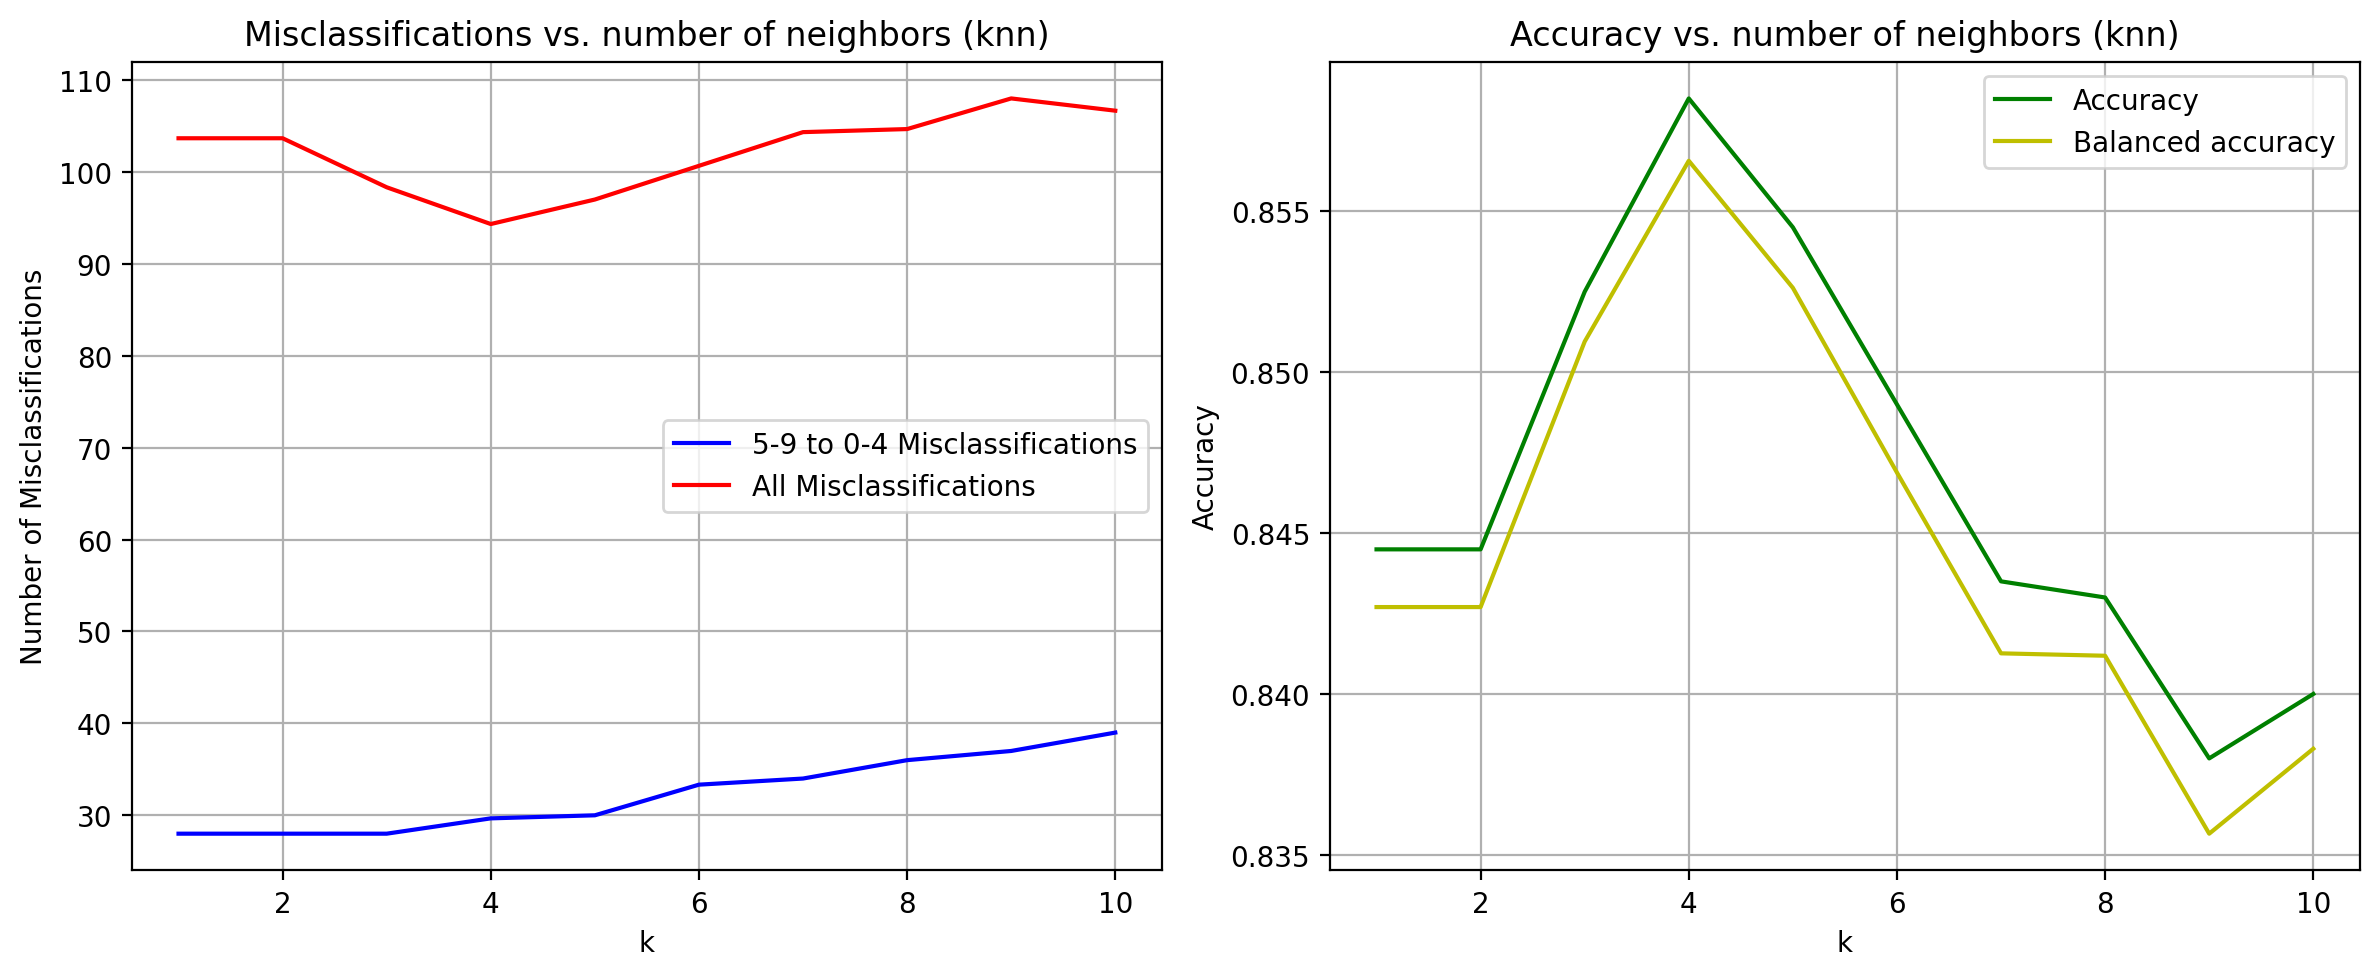

,k,accuracy,balanced_accuracy,all_misclass,sub_misclass
0,1,0.844,0.843,103.667,28.0*
1,2,0.844,0.843,103.667,28.0*
2,3,0.852,0.851,98.333,28.0*
3,4,0.859*,0.857*,94.333*,29.667
4,5,0.855,0.853,97.0,30.0
5,6,0.849,0.847,100.667,33.333
6,7,0.844,0.841,104.333,34.0
7,8,0.843,0.841,104.667,36.0
8,9,0.838,0.836,108.0,37.0
9,10,0.84,0.838,106.667,39.0


In [8]:
plot_results(results, 'k', 'number of neighbors (knn)', 'knn_perf')
results = format_results(results)
results

## Logistic regression

In [9]:
results = []

C_values = np.logspace(-10, 10, 21, base=2)
for C in C_values:
    pipe = Pipeline([
        ('scaler', StandardScaler()), 
        ('logreg', LogisticRegression(C=C, max_iter=10000))]) 
    cv_results = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv=3, 
        scoring={'accuracy': 'accuracy', 
                 'balanced_accuracy': 'balanced_accuracy', 
                 'all_misclass' : all_misclass_counter,
                 'sub_misclass': sub_misclass_counter})
    results.append({
        'C': C,
        'accuracy': np.mean(cv_results['test_accuracy']),
        'balanced_accuracy': np.mean(cv_results['test_balanced_accuracy']),
        'all_misclass': np.mean(cv_results['test_all_misclass']),
        'sub_misclass': np.mean(cv_results['test_sub_misclass'])
    })

results = pd.DataFrame(results)

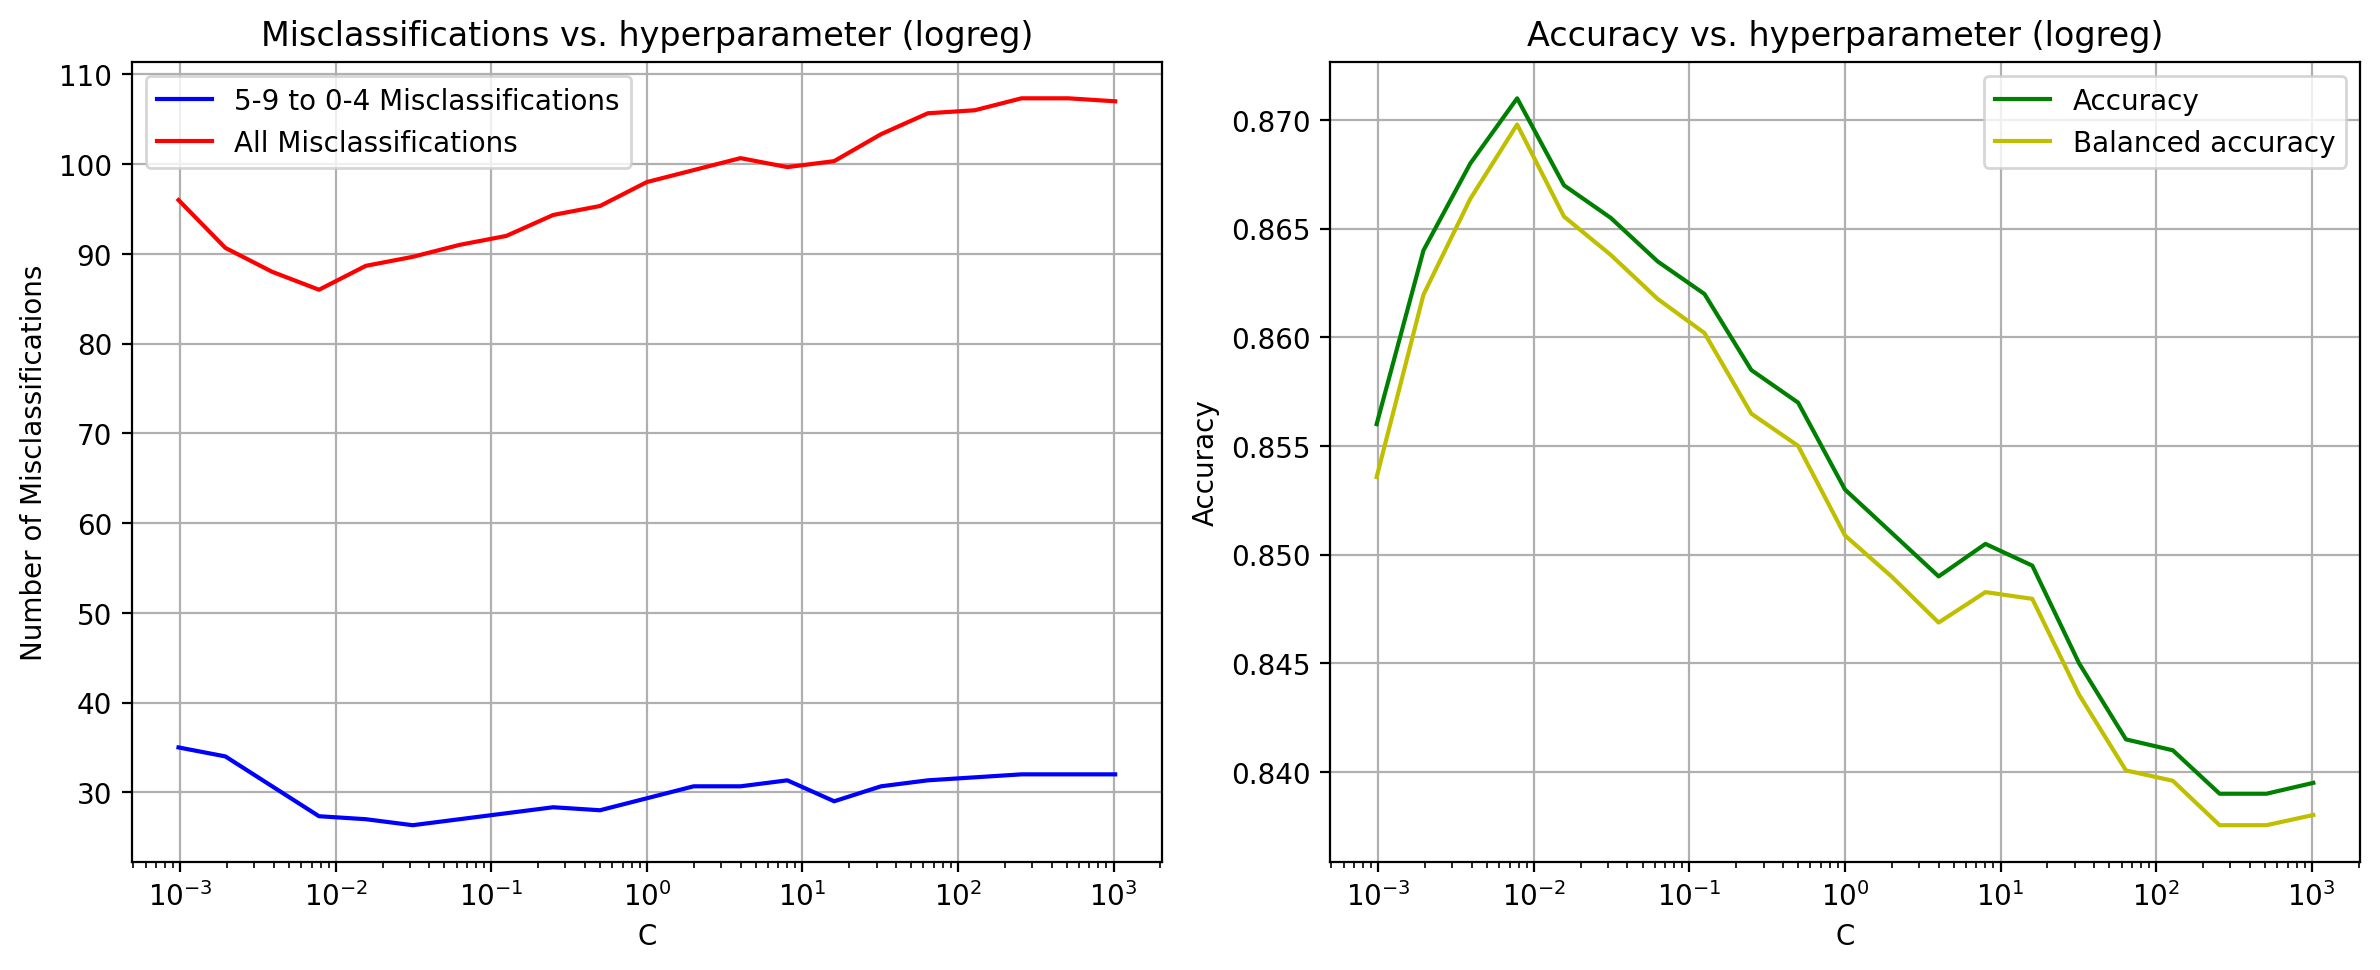

,C,accuracy,balanced_accuracy,all_misclass,sub_misclass
0,0.001,0.856,0.854,96.0,35.0
1,0.002,0.864,0.862,90.667,34.0
2,0.004,0.868,0.866,88.0,30.667
3,0.008,0.871*,0.87*,86.0*,27.333
4,0.016,0.867,0.866,88.667,27.0
5,0.031,0.865,0.864,89.667,26.333*
6,0.062,0.863,0.862,91.0,27.0
7,0.125,0.862,0.86,92.0,27.667
8,0.250,0.858,0.856,94.333,28.333
9,0.500,0.857,0.855,95.333,28.0


In [10]:
plot_results(results, 'C', 'hyperparameter (logreg)', 'logreg_perf')
results = format_results(results)
results

### LinearSVC

In [11]:
results = []

C_values = np.logspace(-10, 10, 21, base=2)
for C in C_values:
    pipe = Pipeline([
        ('scaler', MaxAbsScaler()), 
        ('svc', LinearSVC(C=C, max_iter=15000, dual=True))]) 
    cv_results = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv=3, 
        scoring={'accuracy': 'accuracy', 
                 'balanced_accuracy': 'balanced_accuracy', 
                 'all_misclass' : all_misclass_counter,
                 'sub_misclass': sub_misclass_counter})
    results.append({
        'C': C,
        'accuracy': np.mean(cv_results['test_accuracy']),
        'balanced_accuracy': np.mean(cv_results['test_balanced_accuracy']),
        'all_misclass': np.mean(cv_results['test_all_misclass']),
        'sub_misclass': np.mean(cv_results['test_sub_misclass'])
    })

results = pd.DataFrame(results)

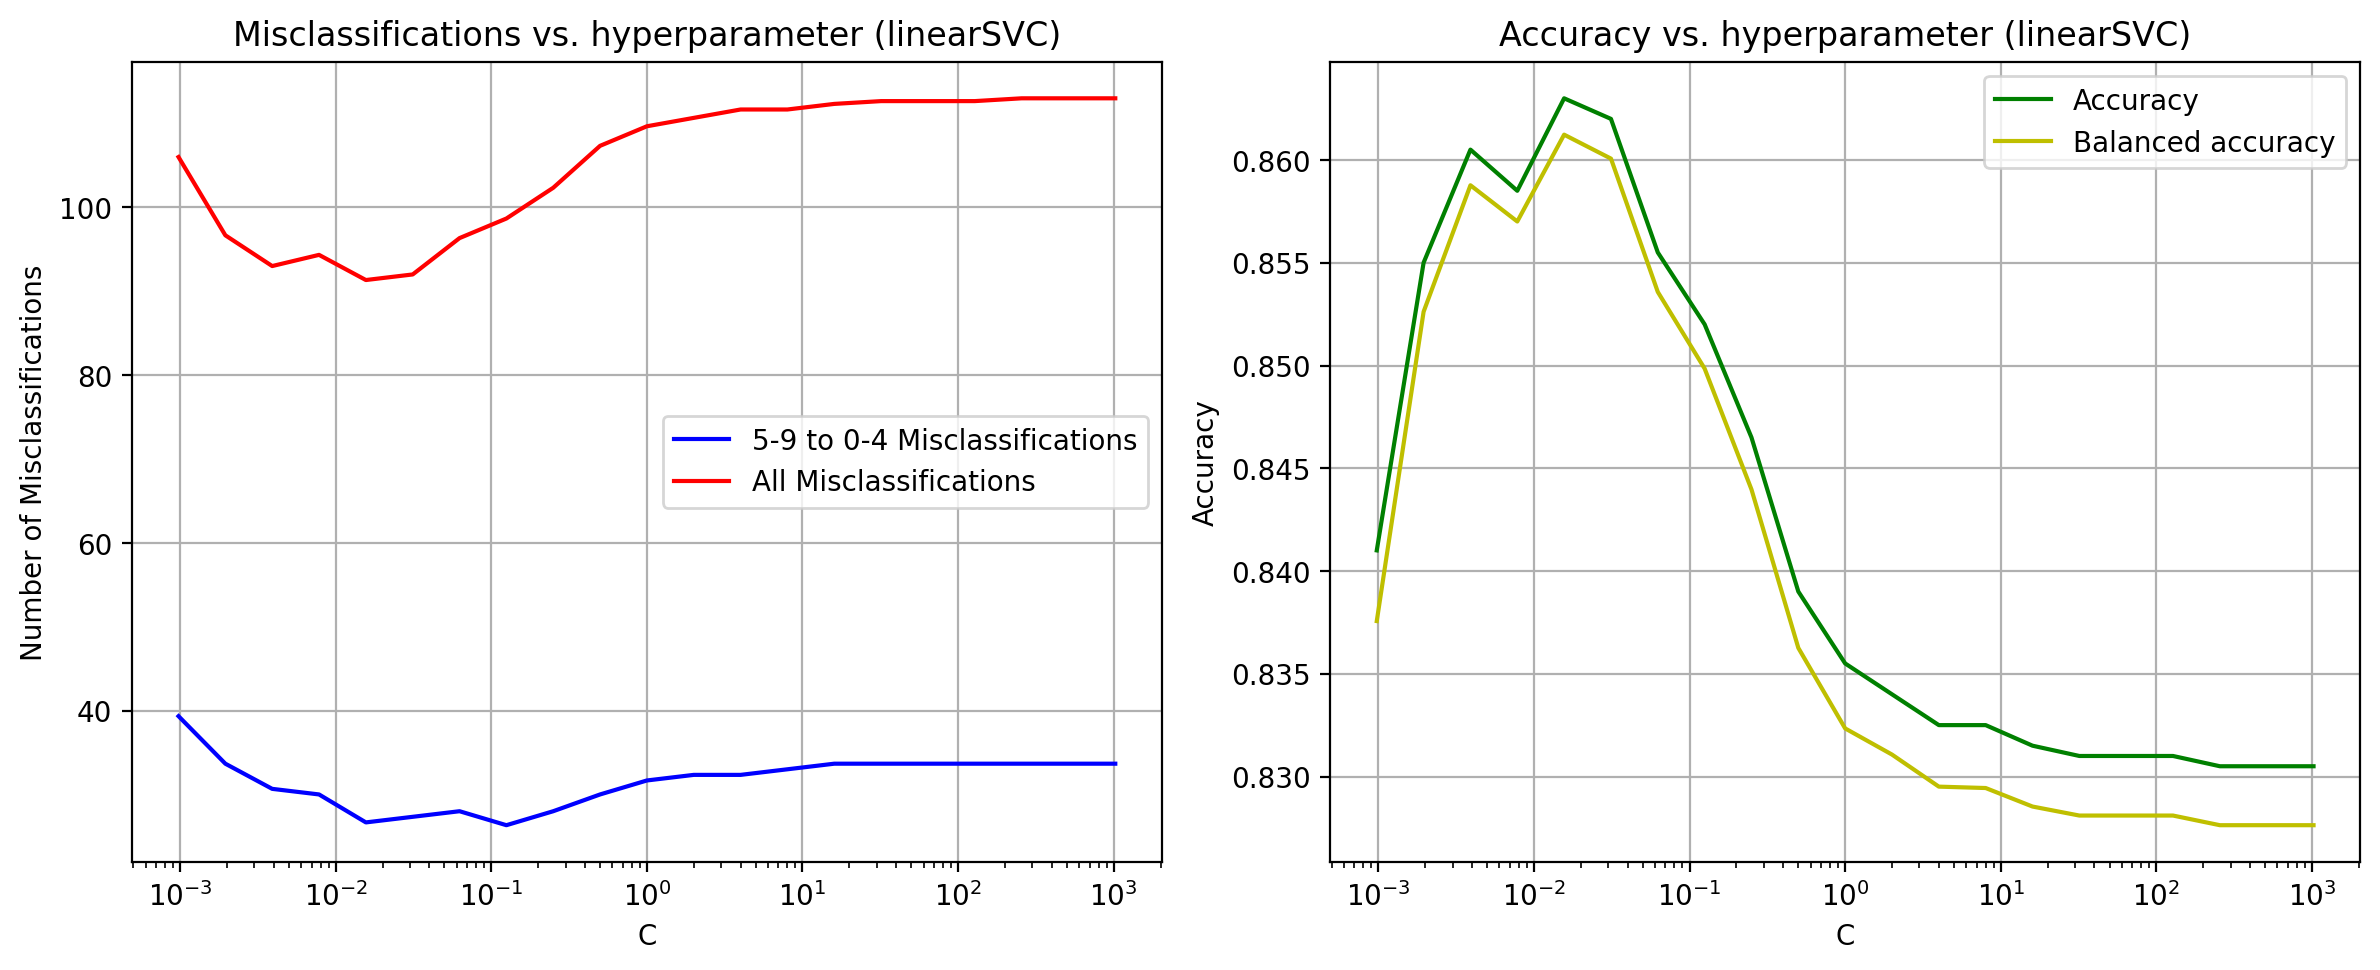

,C,accuracy,balanced_accuracy,all_misclass,sub_misclass
0,0.001,0.841,0.838,106.0,39.333
1,0.002,0.855,0.853,96.667,33.667
2,0.004,0.861,0.859,93.0,30.667
3,0.008,0.859,0.857,94.333,30.0
4,0.016,0.863*,0.861*,91.333*,26.667
5,0.031,0.862,0.86,92.0,27.333
6,0.062,0.856,0.854,96.333,28.0
7,0.125,0.852,0.85,98.667,26.333*
8,0.250,0.846,0.844,102.333,28.0
9,0.500,0.839,0.836,107.333,30.0


In [12]:
plot_results(results, 'C', 'hyperparameter (linearSVC)', 'linearSVC_perf')
results = format_results(results)
results

### SVC

In [13]:
results = []

C_values = np.logspace(-10, 10, 21, base=2)
for C in C_values:
    pipe = Pipeline([
        ('scaler', MaxAbsScaler()), 
        ('svc', SVC(C=C))]) 
    cv_results = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv=3, 
        scoring={'accuracy': 'accuracy', 
                 'balanced_accuracy': 'balanced_accuracy', 
                 'all_misclass': all_misclass_counter,
                 'sub_misclass': sub_misclass_counter})
    results.append({
        'C': C,
        'accuracy': np.mean(cv_results['test_accuracy']),
        'balanced_accuracy': np.mean(cv_results['test_balanced_accuracy']),
        'all_misclass': np.mean(cv_results['test_all_misclass']),
        'sub_misclass': np.mean(cv_results['test_sub_misclass'])
    })

results = pd.DataFrame(results)

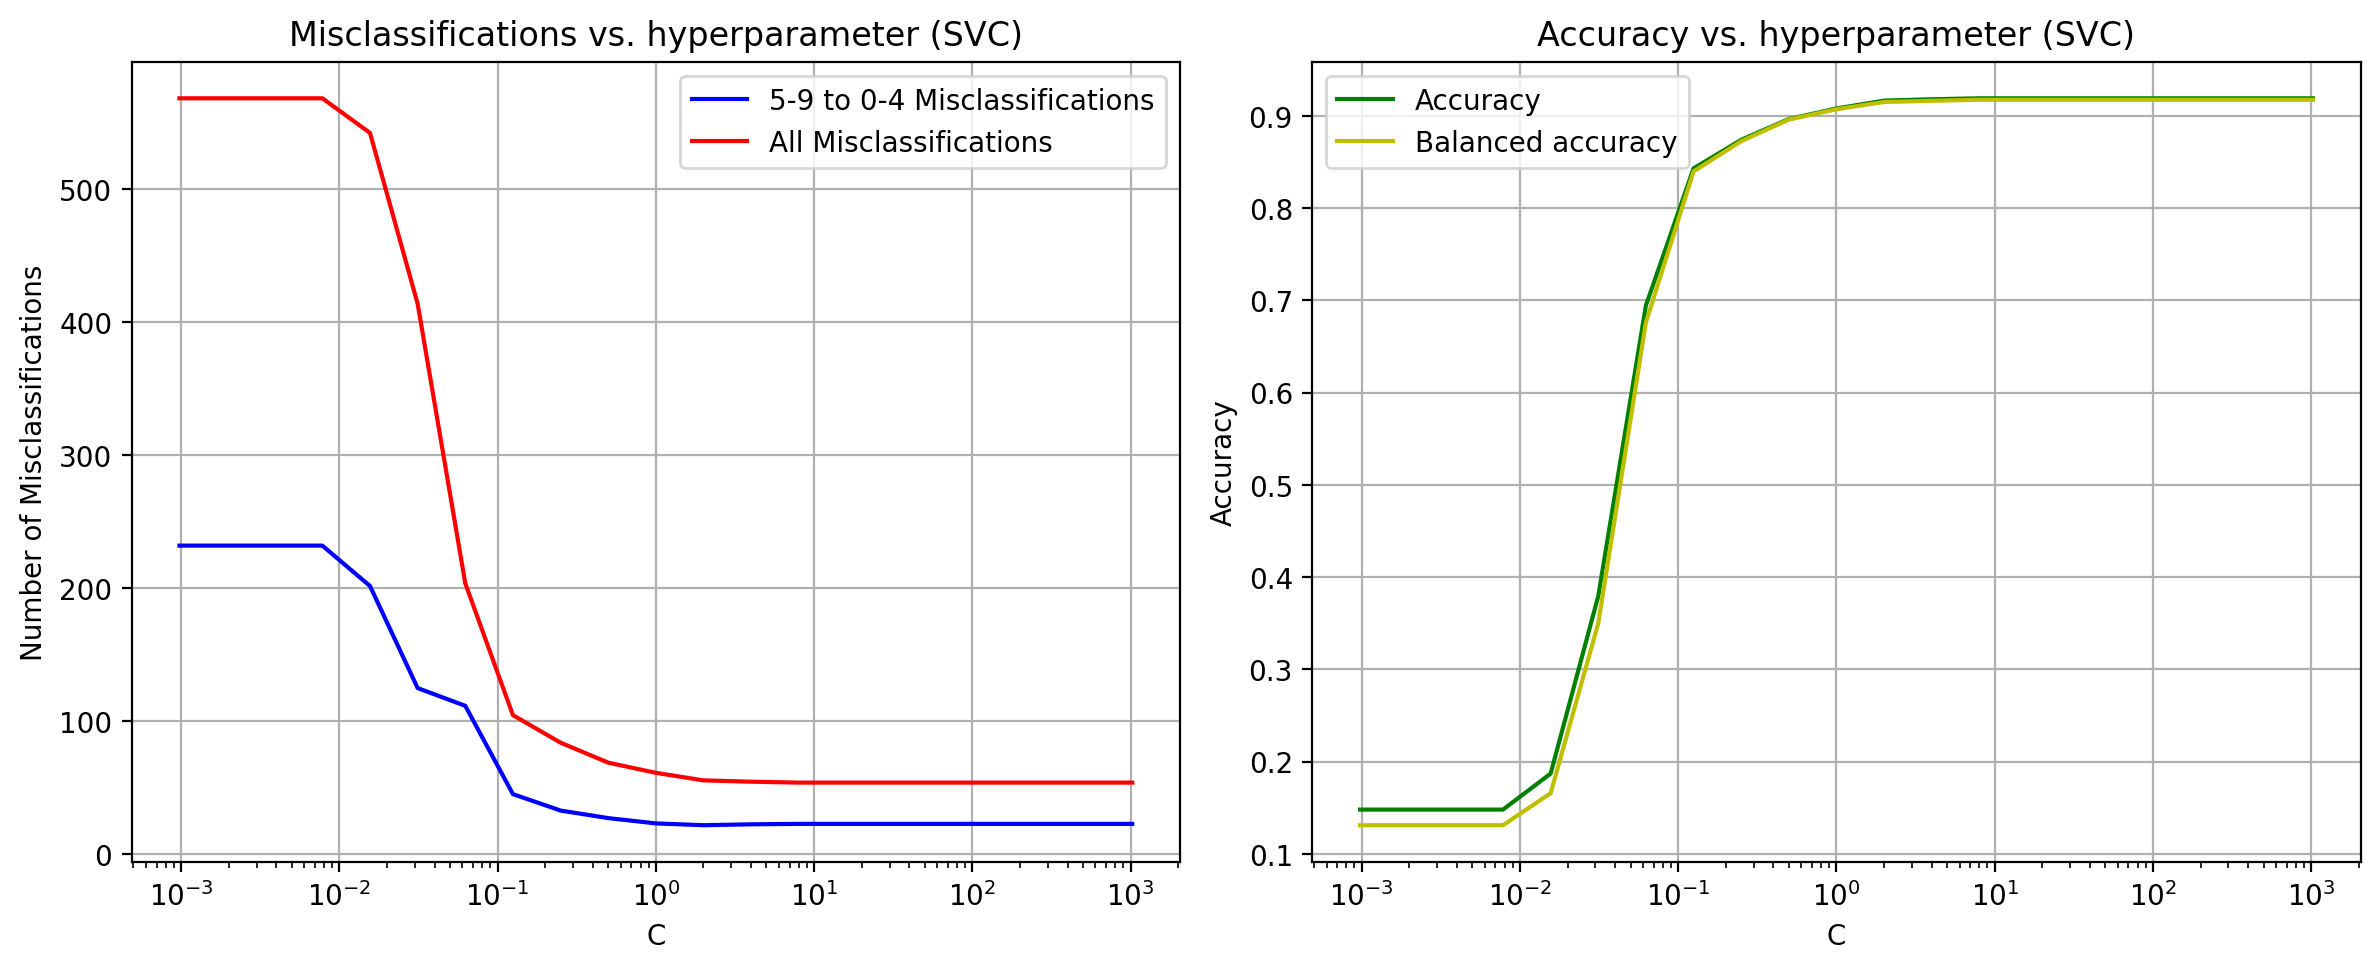

,C,accuracy,balanced_accuracy,all_misclass,sub_misclass
0,0.001,0.148,0.131,568.0,232.0
1,0.002,0.148,0.131,568.0,232.0
2,0.004,0.148,0.131,568.0,232.0
3,0.008,0.148,0.131,568.0,232.0
4,0.016,0.187,0.166,542.0,201.667
5,0.031,0.379,0.35,413.667,125.0
6,0.062,0.694,0.676,203.667,111.667
7,0.125,0.843,0.84,104.667,45.333
8,0.250,0.874,0.873,84.0,33.0
9,0.500,0.897,0.896,69.0,27.333


In [14]:
plot_results(results, 'C', 'hyperparameter (SVC)', 'SVC_perf')
results = format_results(results)
results

### Comment
The existence of a trade-off is doubtfull for ```linearSVC```, as moving from the hyperparameter value maximizingaccuracy to that minimizing the number of 5-9 to 0-4 misclassifications only reduces by 0.3 the average number of such errors (on 3-fold validation). Trade-offs are apparent for all 3 other classifiers, although usually quite thin. The same change of hyperparameter value yields:
- 4 more errors in total but 2 less errors of interest for ```knn```
- 3 more errors overall but 1 less error of interest for ```logreg```
- 2 more errors overall but 1 less error of interest for ```SVC```

The results also confirm that SVC is the most performant algorithm by far.

We write a custom score function applying a penalty equal to $\frac{1}{\ln(e+x)}$ to accuracy, where $x$ is the numbre of 5-9 to 0-4 misclassifications. This penalty decreases logarithmically with the number of misclassifications, as can be seen below. We use accuracy rather than balanced accuracy because we do not want a potential lower frequency of 5-9 digits in the dataset to compensate the effect of the penalty.

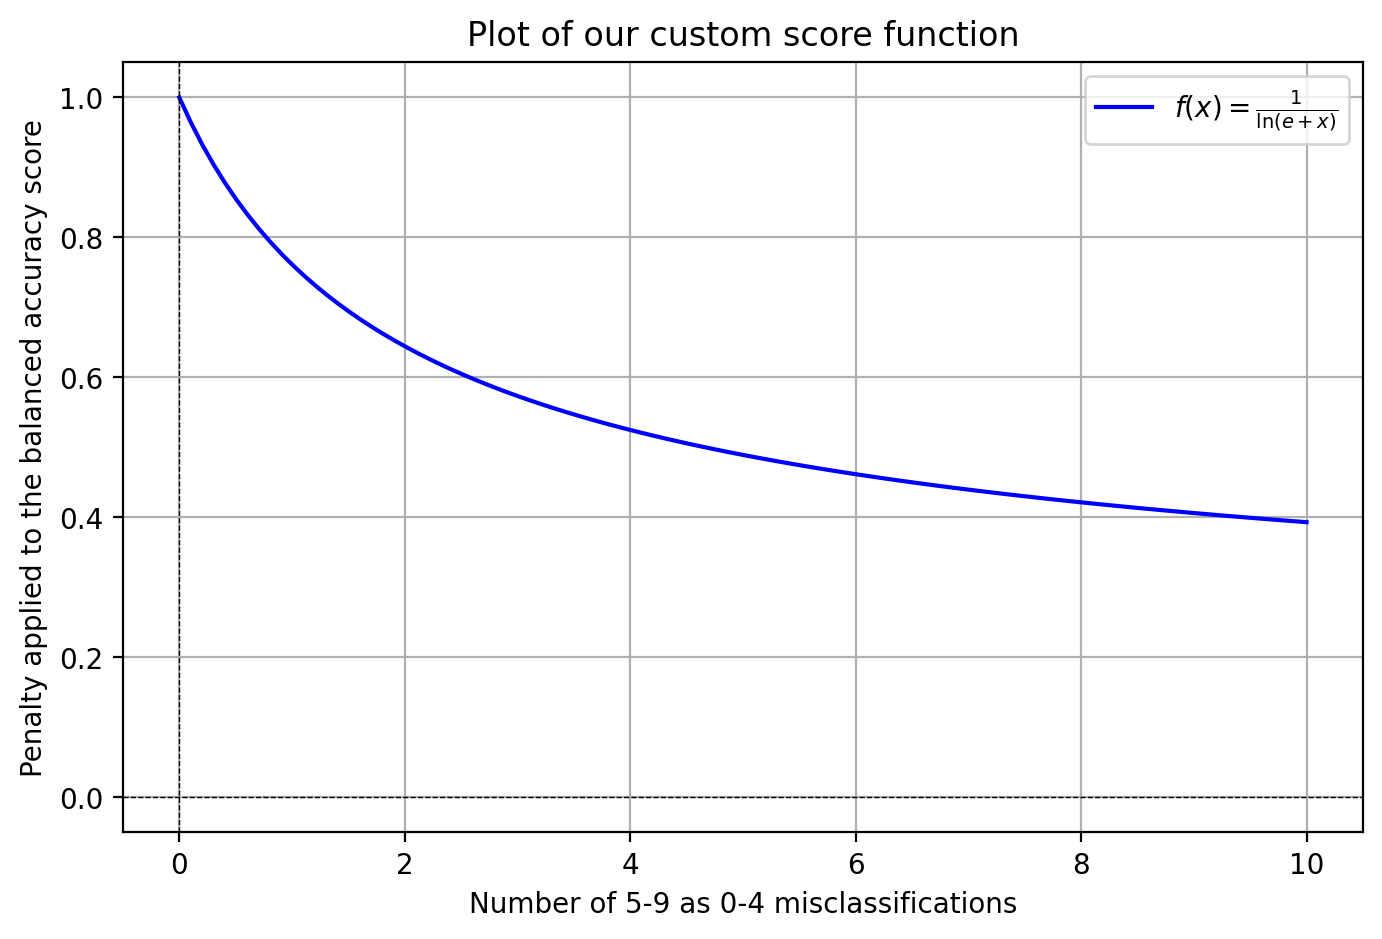

In [15]:
def f(x):
    return (1 / np.log(np.e + x))

x_values = np.linspace(0, 10, 100)
y_values = f(x_values)

plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, label=r'$f(x) = \frac{1}{\ln(e + x)}$', color='blue')
plt.title('Plot of our custom score function')
plt.xlabel('Number of 5-9 as 0-4 misclassifications')
plt.ylabel('Penalty applied to the balanced accuracy score')
plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.show()

In [16]:
def penalized_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    misclassifications = np.sum((y_pred < 5) & (y_true >= 5))
    score = accuracy / np.log(np.e + misclassifications)
    return score

def sub_misclass_score(y_true, y_pred):
    sub_misclass = np.sum((y_pred < 5) & (y_true >= 5))
    score = sub_misclass ** 2
    return score

custom_scorer = make_scorer(penalized_score, greater_is_better=True)
sub_misclass_scorer = make_scorer(sub_misclass_score, greater_is_better=False)

### Example 1: knn
We apply our custom score function to the search for the best hyperparameter value for a knn classifier.

In [17]:
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
parameters7 = {'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
clf7 = GridSearchCV(pipe, 
                    parameters7, 
                    cv=3, 
                    scoring={'accuracy': 'accuracy', 
                             'penalized_score': custom_scorer,
                             'nb_misclass': sub_misclass_scorer}, 
                    refit=False)
clf7.fit(X_train, y_train)

best_k_penalized = clf7.cv_results_['param_knn__n_neighbors'][np.argmax(clf7.cv_results_['mean_test_penalized_score'])]
best_k_misclass = clf7.cv_results_['param_knn__n_neighbors'][np.argmax(clf7.cv_results_['mean_test_nb_misclass'])]
best_k_accuracy = clf7.cv_results_['param_knn__n_neighbors'][np.argmax(clf7.cv_results_['mean_test_accuracy'])]

In [18]:
def refit_knn_model(metric, k_val):
    pipe.set_params(knn__n_neighbors=k_val)
    pipe.fit(X_train, y_train)
    clf9 = pipe

    acc_train = accuracy_score(y_train, 
                               clf9.predict(X_train))
    acc_test = accuracy_score(y_test, 
                              clf9.predict(X_test))
    cm = confusion_matrix(y_test, 
                          clf9.predict(X_test))
    sub_misclass = np.sum(cm[5:10, 0:5])
    tot_misclass = np.sum(cm - np.diag(np.diag(cm)))

    print(metric)
    print(f"Best k: {k_val}")
    print('Accuracy on training: {:.4f}'.format(acc_train))
    print('Accuracy on test: {:.4f}'.format(acc_test))
    print('Number of 5-9 misclassified as 0-4: {}'.format(sub_misclass))
    print('Total number of misclassifications: {}'.format(tot_misclass))
    print(cm)

In [19]:
refit_knn_model('Penalized accuracy', best_k_penalized)
print('\n')
refit_knn_model('Number of 5-9 as 0-4 misclassifications', best_k_misclass)
print('\n')
refit_knn_model('Accuracy', best_k_accuracy)

Penalized accuracy
Best k: 1
Accuracy on training: 1.0000
Accuracy on test: 0.8350
Number of 5-9 misclassified as 0-4: 12
Total number of misclassifications: 33
[[21  0  0  0  0  1  0  0  0  0]
 [ 0 25  0  1  0  0  0  0  0  0]
 [ 0  0 14  0  0  1  0  0  0  1]
 [ 0  0  1 17  0  3  0  0  1  1]
 [ 0  2  0  0 16  0  0  0  0  2]
 [ 0  1  0  0  0  8  0  0  1  0]
 [ 2  1  0  0  0  0 21  0  0  0]
 [ 0  0  0  0  1  0  0 13  0  2]
 [ 0  2  0  1  0  1  0  0 13  0]
 [ 1  1  0  0  2  0  0  3  0 19]]


Number of 5-9 as 0-4 misclassifications
Best k: 1
Accuracy on training: 1.0000
Accuracy on test: 0.8350
Number of 5-9 misclassified as 0-4: 12
Total number of misclassifications: 33
[[21  0  0  0  0  1  0  0  0  0]
 [ 0 25  0  1  0  0  0  0  0  0]
 [ 0  0 14  0  0  1  0  0  0  1]
 [ 0  0  1 17  0  3  0  0  1  1]
 [ 0  2  0  0 16  0  0  0  0  2]
 [ 0  1  0  0  0  8  0  0  1  0]
 [ 2  1  0  0  0  0 21  0  0  0]
 [ 0  0  0  0  1  0  0 13  0  2]
 [ 0  2  0  1  0  1  0  0 13  0]
 [ 1  1  0  0  2  0  0  3  

NB: the number of misclassifications is much lower than before because we now work on the test dataset, which has 10 times less observations than the train dataset. We see that compared to accuracy, our custom score function leads ```gridsearchCV```to select a different value of $k$, yielding one less relevant misclassification but one more misclassification overall.

### Example 2: SVC

In [20]:
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', SVC(probability=False))])
parameters10 = {'svc__C': np.logspace(-10, 10, 21, base=2)}
clf10 = GridSearchCV(pipe, 
                    parameters10, 
                    cv=3, 
                    scoring={'accuracy': 'accuracy', 
                             'penalized_score': custom_scorer,
                             'nb_misclass': sub_misclass_scorer}, 
                    refit=False,
                    n_jobs=-1,
                    verbose=0)
clf10.fit(X_train, y_train)

best_C_accuracy = clf10.cv_results_['param_svc__C'][np.argmax(clf10.cv_results_['mean_test_accuracy'])]
best_C_misclass = clf10.cv_results_['param_svc__C'][np.argmax(clf10.cv_results_['mean_test_nb_misclass'])]
best_C_penalized = clf10.cv_results_['param_svc__C'][np.argmax(clf10.cv_results_['mean_test_penalized_score'])]

In [21]:
def refit_svc_model(metric, C_val):
    pipe.set_params(svc__C=C_val)
    pipe.fit(X_train, y_train)
    clf12 = pipe

    acc_train = accuracy_score(y_train, 
                               clf12.predict(X_train))
    acc_test = accuracy_score(y_test, 
                              clf12.predict(X_test))
    cm = confusion_matrix(y_test, 
                          clf12.predict(X_test))
    sub_misclass = np.sum(cm[5:10, 0:5])
    tot_misclass = np.sum(cm - np.diag(np.diag(cm)))

    print(metric)
    print(f"Best C: {C_val}")
    print('Accuracy on training: {:.4f}'.format(acc_train))
    print('Accuracy on test: {:.4f}'.format(acc_test))
    print('Number of 5-9 misclassified as 0-4: {}'.format(sub_misclass))
    print('Total number of misclassifications: {}'.format(tot_misclass))
    print(cm)

In [22]:
refit_svc_model('Penalized accuracy', best_C_penalized)
print('\n')
refit_svc_model('Number of 5-9 as 0-4 misclassifications', best_C_misclass)
print('\n')
refit_svc_model('Accuracy', best_C_accuracy)

Penalized accuracy
Best C: 2.0
Accuracy on training: 0.9965
Accuracy on test: 0.9400
Number of 5-9 misclassified as 0-4: 4
Total number of misclassifications: 12
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  1  1  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  0  0  1]
 [ 0  0  1  0 18  0  0  0  0  1]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  1  1  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0]
 [ 0  1  0  1  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  1  1 24]]


Number of 5-9 as 0-4 misclassifications
Best C: 2.0
Accuracy on training: 0.9965
Accuracy on test: 0.9400
Number of 5-9 misclassified as 0-4: 4
Total number of misclassifications: 12
[[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  1  1  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  1  0  0  0  1]
 [ 0  0  1  0 18  0  0  0  0  1]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  1  1  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0]
 [ 0  1  0  1  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  1

The result we obtained with ```knn``` cannot be replicated with ```SVC```, as seen below: this algorithm is too effective, and the test dataset too small, for our custom scorer to make a difference. This confirms that in certain circumstances, a custom score may not be necessary to minimize the number of 5-9 to 0-4 misclassifications.

Using the complete MNIST dataset...
- Score is still effective for ```knn```: reduces the number of 5-9 misclassed as 0-4 from 197 to 188, raises the total number of errors from 557 to 566, and reduces test accuracy from 0.944 to 0.943 (from k=5 to k=1)
- For ```svc``` the score actually degrades overall performance, going from 164 to 167 misclassifications errors in total, without any effect on 5-9 to 0-4 misclassifications errors, remaining at 70.